### INFO
This document details a portion of a project focused on extracting data from the Steam using SteamSPY and Steam itself.
The main aim is not only to create a categorized list of Steam games and their associated application IDs (appids) but also to collect additional characteristics like genres attributed to these games. 

The main motive of this code lies in gathering crucial insights intended for research, specifically within the realm of the gaming industry. This method aids researchers in securing a thorough inventory of Steam games along with their appids and relevant specifics, creating a basis for various analyses.

It's important to acknowledge that future versions of this project might integrate more diverse data sources and implement enhancements for refined data collection and interpretation (steam charts for example). 

The inspiration for this code have been sourced from Nik Davis, whose blog post provided crucial tips and direction for the creation of this data extraction process. You can visit his page here.

### IMPORTS

In [1]:
# standard library imports
import csv
import datetime as dt
import json
import os
import statistics
import time

# additional imports
import numpy as np
import pandas as pd
import requests

# customisations - ensure tables show all columns
pd.set_option("display.max_columns", None)

### The function follows a recursive approach to handle retries in case of errors. However, there are a few improvements that can be made to the code. Here's an updated version of the function with some enhancements:
The provided code snippet is part of a bachelor paper and focuses on retrieving data from the SteamSpy API to generate a sorted list of Steam applications (games) and their corresponding application IDs (appids). It uses the SteamSpy API endpoint URL and makes multiple requests to retrieve data from different pages. The retrieved data is aggregated into a Pandas DataFrame and processed to extract the desired columns. Finally, the sorted DataFrame is exported to a CSV file. This code can be valuable for research purposes related to the gaming industry, providing a comprehensive list of Steam applications and their appids for further analysis.

In [2]:
import requests
import time

def get_request(url, parameters=None, max_retries=3, retry_delay=5):
    """Return JSON-formatted response of a GET request using optional parameters.
    
    Parameters
    ----------
    url : string
        URL for the GET request.
    parameters : dict, optional
        Parameters to pass as part of the GET request.
    max_retries : int, optional
        Maximum number of retries in case of errors. Default is 3.
    retry_delay : int, optional
        Delay in seconds between retries. Default is 5.
    
    Returns
    -------
    json_data : dict or None
        JSON-formatted response (dict-like) or None if there is no response.
    """
    for retry in range(max_retries):
        try:
            response = requests.get(url=url, params=parameters)
            response.raise_for_status()  # Raise an exception for any HTTP error status
            return response.json()
        except (requests.RequestException, ValueError) as e:
            print('An error occurred:', str(e))
            print(f'Retrying ({retry+1}/{max_retries})...')
            time.sleep(retry_delay)
    
    print(f'Exceeded maximum retries ({max_retries}). Giving up.')
    return None


In [4]:
dane_path = ""

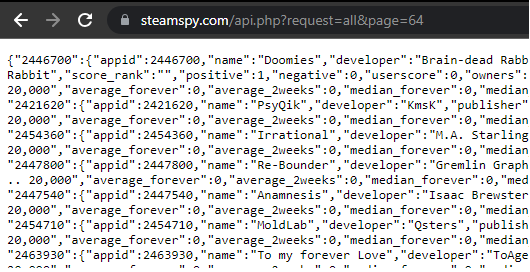

In [9]:
# the upper part (60), for now, may need to be searched by hand through this -> https://steamspy.com/api.php?request=all&page=64 where 64 is max page for this moment in time (july). You can paste it in url. 
from IPython.display import Image
Image("")

In [26]:
url = "https://steamspy.com/api.php"
json_data_2 = {}
for i in range(0,60):
    parameters = {"request": "all","page":f"{i}"}
    # request 'all' from steam spy and parse into dataframe
    json_data = get_request(url, parameters=parameters)
    json_data_2.update(json_data)
steam_spy_all = pd.DataFrame.from_dict(json_data_2, orient='index')
# generate sorted app_list from steamspy data
app_list = steam_spy_all[['appid', 'name']].sort_values('appid').reset_index(drop=True)

# export disabled to keep consistency across download sessions
#app_list.to_csv(f'{dane_path}app_list.csv', index=False)

In [27]:
import pandas as pd
# instead read from stored csv
app_list = pd.read_csv(f'{dane_path}app_list.csv')

# display first few rows
app_list.head()

,appid,name
0,10,Counter-Strike
1,20,Team Fortress Classic
2,30,Day of Defeat
3,40,Deathmatch Classic
4,50,Half-Life: Opposing Force


## get_app_data, process_batches
The provided code consists of two functions: get_app_data and process_batches. These functions are designed to retrieve and process app data in batches, and then write the data to files.

The get_app_data function retrieves app data using a supplied parser function. It takes a range of indices from the app_list dataframe, iterates through the specified rows, and calls the parser function for each app. The retrieved data is appended to a list, and a pause is included between requests to avoid overloading the API. The function returns the list of app data.

The process_batches function handles the processing and writing of app data in batches. It takes a parser function, app_list dataframe, download path, filenames for data and index files, column names, starting and ending indices, batch size, and pause time as input. The function splits the app data into batches and calls get_app_data for each batch. The app data is then written to a CSV file, and the index of the last written app is stored in an index file. The function also logs the time taken for each batch and estimates the remaining time based on the average processing time. Finally, it prints the number of apps written to the files.

By using these functions, the code enables efficient processing and storage of app data in batches, which can be useful for managing large datasets and adhering to API limitations.

In [28]:
def get_app_data(start, stop, parser, pause):
    """Return list of app data generated from parser.
    
    parser : function to handle request
    """
    app_data = []
    
    # iterate through each row of app_list, confined by start and stop
    for index, row in app_list[start:stop].iterrows():
        print('Current index: {}'.format(index), end='\r')
        
        appid = row['appid']
        name = row['name']

        # retrive app data for a row, handled by supplied parser, and append to list
        data = parser(appid, name)
        app_data.append(data)

        time.sleep(pause) # prevent overloading api with requests
    
    return app_data


def process_batches(parser, app_list, download_path, data_filename, index_filename,
                    columns, begin=0, end=-1, batchsize=1, pause=1):
    """Process app data in batches, writing directly to file.
    
    parser : custom function to format request
    app_list : dataframe of appid and name
    download_path : path to store data
    data_filename : filename to save app data
    index_filename : filename to store highest index written
    columns : column names for file
    
    Keyword arguments:
    
    begin : starting index (get from index_filename, default 0)
    end : index to finish (defaults to end of app_list)
    batchsize : number of apps to write in each batch (default 100)
    pause : time to wait after each api request (defualt 1)
    
    returns: none
    """
    print('Starting at index {}:\n'.format(begin))
    
    # by default, process all apps in app_list
    if end == -1:
        end = len(app_list) + 1
    
    # generate array of batch begin and end points
    batches = np.arange(begin, end, batchsize)
    batches = np.append(batches, end)
    
    apps_written = 0
    batch_times = []
    
    for i in range(len(batches) - 1):
        start_time = time.time()
        
        start = batches[i]
        stop = batches[i+1]
        
        app_data = get_app_data(start, stop, parser, pause)
        
        rel_path = os.path.join(download_path, data_filename)
        
        # writing app data to file
        with open(rel_path, 'a', newline='', encoding='utf-8') as f:
            writer = csv.DictWriter(f, fieldnames=columns, extrasaction='ignore')
            
            for j in range(3,0,-1):
                print("\rAbout to write data, don't stop script! ({})".format(j), end='')
                time.sleep(0.5)
            
            writer.writerows(app_data)
            print('\rExported lines {}-{} to {}.'.format(start, stop-1, data_filename), end=' ')
            
        apps_written += len(app_data)
        
        idx_path = os.path.join(download_path, index_filename)
        
        # writing last index to file
        with open(idx_path, 'w') as f:
                index = stop
                print(index, file=f)
            
        # logging time taken
        end_time = time.time()
        time_taken = end_time - start_time
        
        batch_times.append(time_taken)
        mean_time = statistics.mean(batch_times)
        
        est_remaining = (len(batches) - i - 2) * mean_time
        
        remaining_td = dt.timedelta(seconds=round(est_remaining))
        time_td = dt.timedelta(seconds=round(time_taken))
        mean_td = dt.timedelta(seconds=round(mean_time))
        
        print('Batch {} time: {} (avg: {}, remaining: {})'.format(i, time_td, mean_td, remaining_td))
            
    print('\nProcessing batches complete. {} apps written'.format(apps_written))

## reset_index, get_index, prepare_data_file 
The additional code snippet includes three functions: reset_index, get_index, and prepare_data_file, which are aimed at managing the index and preparing the data file for storing app data.

The reset_index function sets the index in the index file to 0, effectively resetting it. It takes the download path and index filename as input, opens the file, and writes the value 0 to reset the index.

The get_index function retrieves the index value from the index file. It takes the download path and index filename as input, attempts to open the file, and reads the index value. If the file is not found, it returns a default index value of 0.

The prepare_data_file function prepares the data file for storing app data. It takes the download path, filename, index, and column names as input. If the index is 0, indicating a new file or a reset index, the function opens the file, writes the column headers, and sets up the file for subsequent data storage.

These functions contribute to managing the storage of app data by providing mechanisms for resetting the index, retrieving the current index value, and preparing the data file with proper headers. These operations are crucial for ensuring the integrity and organization of the data being stored in the context of the bachelor thesis.

In [29]:
def reset_index(download_path, index_filename):
    """Reset index in file to 0."""
    rel_path = os.path.join(download_path, index_filename)
    
    with open(rel_path, 'w') as f:
        print(0, file=f)
        

def get_index(download_path, index_filename):
    """Retrieve index from file, returning 0 if file not found."""
    try:
        rel_path = os.path.join(download_path, index_filename)

        with open(rel_path, 'r') as f:
            index = int(f.readline())
    
    except FileNotFoundError:
        index = 0
        
    return index


def prepare_data_file(download_path, filename, index, columns):
    """Create file and write headers if index is 0."""
    if index == 0:
        rel_path = os.path.join(download_path, filename)

        with open(rel_path, 'w', newline='') as f:
            writer = csv.DictWriter(f, fieldnames=columns)
            writer.writeheader()

## 
The provided code performs data retrieval and processing from the Steam Store API for Steam applications. It includes a custom parser function to handle data from the API. The code sets up file parameters and prepares the data file for writing. It retrieves the last downloaded index from the index file. The data processing is done in batches using the process_batches function, which calls the parser function for each app in the app list. The processed data is written to a CSV file. The code handles different scenarios, such as resetting the index, retrieving the last index, and error handling. Overall, it provides a structured approach to retrieve and store Steam app data from the API.

In [ ]:
def parse_steam_request(appid, name):
    """Unique parser to handle data from Steam Store API.
    
    Returns : json formatted data (dict-like)
    """
    url = "http://store.steampowered.com/api/appdetails/"
    parameters = {"appids": appid}
    
    json_data = get_request(url, parameters=parameters)
    json_app_data = json_data[str(appid)]
    
    if json_app_data['success']:
        data = json_app_data['data']
    else:
        data = {'name': name, 'steam_appid': appid}
        
    return data


# Set file parameters
download_path = dane_path
steam_app_data = 'steam_app_data.csv'
steam_index = 'steam_index.txt'

steam_columns = [
    'type', 'name', 'steam_appid', 'required_age', 'is_free', 'controller_support',
    'dlc', 'detailed_description', 'about_the_game', 'short_description', 'fullgame',
    'supported_languages', 'header_image', 'website', 'pc_requirements', 'mac_requirements',
    'linux_requirements', 'legal_notice', 'drm_notice', 'ext_user_account_notice',
    'developers', 'publishers', 'demos', 'price_overview', 'packages', 'package_groups',
    'platforms', 'metacritic', 'reviews', 'categories', 'genres', 'screenshots',
    'movies', 'recommendations', 'achievements', 'release_date', 'support_info',
    'background', 'content_descriptors'
] 

# Overwrites last index for demonstration (would usually store highest index so can continue across sessions)
#reset_index(download_path, steam_index)

# Retrieve last index downloaded from file
index = get_index(download_path, steam_index)

# Wipe or create data file and write headers if index is 0
prepare_data_file(download_path, steam_app_data, index, steam_columns)

# Set end and chunksize for demonstration - remove to run through entire app list
try:
    process_batches(
    parser=parse_steam_request,
    app_list=app_list,
    download_path=download_path,
    data_filename=steam_app_data,
    index_filename=steam_index,
    columns=steam_columns,
    begin=index,
    batchsize=100
)
except ValueError:
    process_batches(
    parser=parse_steam_request,
    app_list=app_list,
    download_path=download_path,
    data_filename=steam_app_data,
    index_filename=steam_index,
    columns=steam_columns,
    begin=index+1,
    batchsize=1
)

Starting at index 2400:

Exported lines 2400-2499 to steam_app_data.csv. Batch 0 time: 0:02:52 (avg: 0:02:52, remaining: 1 day, 2:37:43)
